1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

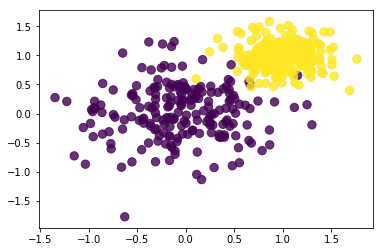

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

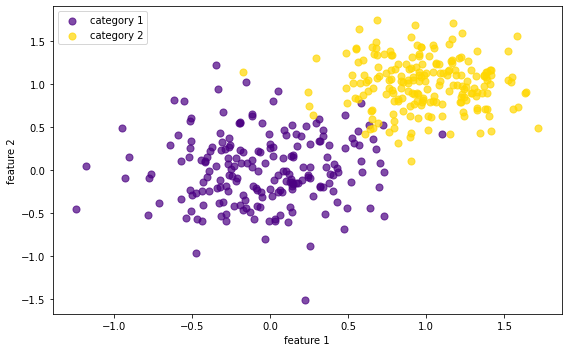

In [3]:
def generate_dataset(n_samples, m1, std1, m2, std2, seed=0):
    """Generate a 2D dataset with two gaussian distributed categories"""
    rng = np.random.default_rng(seed)
    class1 = rng.normal(loc=m1, scale=std1, size=(n_samples, 2))    
    class2 = rng.normal(loc=m2, scale=std2, size=(n_samples, 2))
    return class1, class2

c1, c2 = generate_dataset(200, (0., 0.), (.4, .4), (1., 1.), (.3, .3))
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(c1[:, 0], c1[:, 1], s=50, c='indigo', alpha=0.7, label='category 1')
ax.scatter(c2[:, 0], c2[:, 1], s=50, c='gold', alpha=0.7, label='category 2')
ax.legend(loc='upper left')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
fig.tight_layout()

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [4]:
content = pd.read_pickle('data/residuals_261.pkl')

# check the content of the .pkl file
print(type(content))

data = np.array(content, ndmin=1)[0]
print(data)

df = pd.DataFrame(data)

# filter the dataframe
df = df[df['residuals'].abs() < 2.]
df

<class 'numpy.ndarray'>
{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])}


,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


A very small (positive) correlation between distances and residuals can be observed


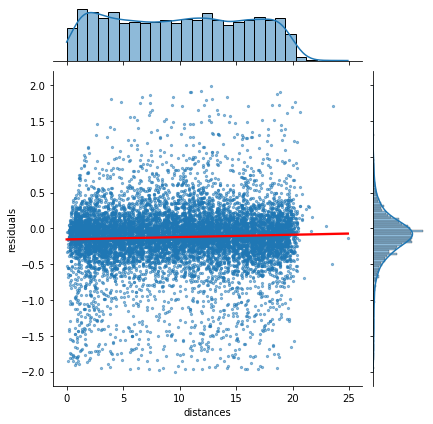

In [5]:
sns.jointplot(x='distances', y='residuals', data=df, kind='reg',
              scatter_kws={'alpha':0.5, 's':5},
              line_kws={'color':'red'})
print('A very small (positive) correlation between distances and residuals can be observed')

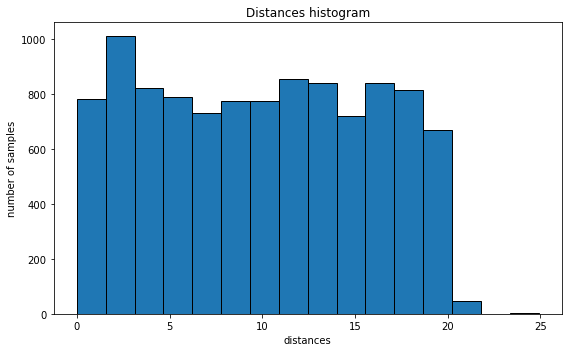

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
h, bins, _ = ax.hist(df['distances'], bins='doane', edgecolor='black')
ax.set_title('Distances histogram')
ax.set_xlabel('distances')
ax.set_ylabel('number of samples')
fig.tight_layout()

x: [ 0.778125  2.334375  3.890625  5.446875  7.003125  8.559375 10.115625
 11.671875 13.228125 14.784375 16.340625 17.896875 19.453125 21.009375
 22.565625 24.121875] 

y: [-0.18665209 -0.17263916 -0.1378287  -0.13511348 -0.08685467 -0.09381726
 -0.06376835 -0.08572962 -0.12233701 -0.15546808 -0.12671695 -0.14773842
 -0.06237178  0.10098278  0.02857143  0.36047619] 

err_y: [0.4616766  0.42396962 0.39543918 0.4135719  0.45540505 0.42584955
 0.41474854 0.48529651 0.4771956  0.4667212  0.43880205 0.41106943
 0.3977452  0.44126358        nan 1.18338526] 



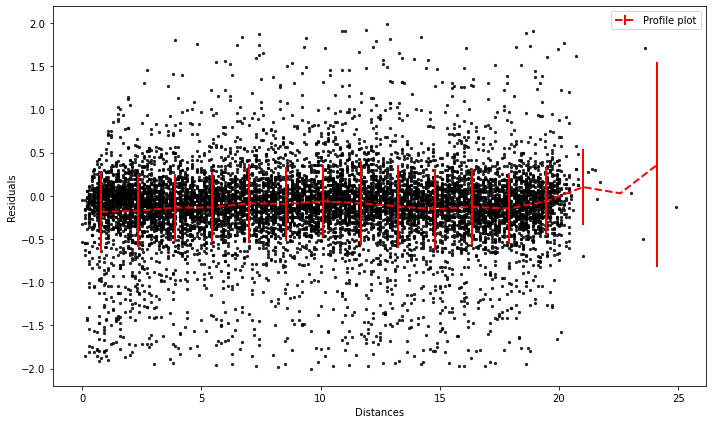

In [7]:
# midpoints of the bins
x = (bins[:-1] + bins[1:]) / 2.
print('x:', x, '\n')

# add a new column to the df that for each entry tells which is index of the closest mid-poin bin
df['x_idx'] = df['distances'].apply(lambda a: np.argmin(np.abs(a - x)))

# compute the mean of the residuals in each bin
y = df.groupby('x_idx')['residuals'].mean().sort_index().values
print('y:', y, '\n')

# compute the std of the residuals in each bin
err_y = df.groupby('x_idx')['residuals'].std().sort_index().values
print('err_y:', err_y, '\n')

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['distances'], df['residuals'], s=20, c='black', marker='.', alpha=.8)
ax.errorbar(x, y, yerr=err_y, c='red', ls='--', lw=2, label='Profile plot')
ax.legend()
ax.set_xlabel('Distances')
ax.set_ylabel('Residuals')
fig.tight_layout()

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


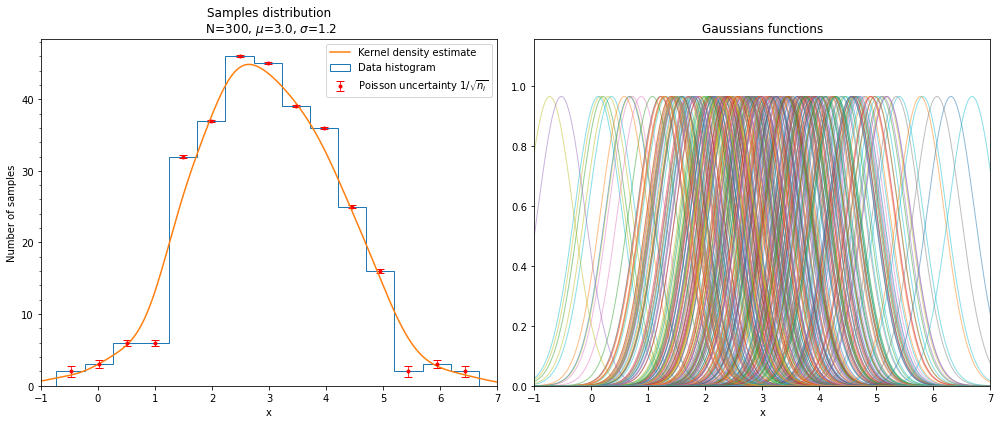

In [8]:
import math
import scipy.stats as stats
from matplotlib.ticker import MultipleLocator

mean, std = 3.0, 1.2
N = 300

# generate random samples
rng = np.random.default_rng(seed=0)
x = rng.normal(loc=mean, scale=std, size=(N,))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# plot the histogram
h, bins, _ = ax1.hist(x, bins='auto', histtype='step', label='Data histogram')

# plot the Poisson uncertainties
centers = .5*(bins[:-1] + bins[1:])
h_err = np.divide(1, np.sqrt(h), where=h!=0)
ax1.errorbar(centers, h, yerr=h_err, color='r', fmt='.',
             linewidth=.8, capsize=4, label='Poisson uncertainty $1/\sqrt{n_i}$')

# perform kernel density estimation
support = x.max() - x.min()
x_dense = np.linspace(x.min()-support/2, x.max()+support/2, num=1000)

std_kde = 1.06 * x.std() * math.pow(x.size, -.2)

# generate all the gaussians
gaussians = stats.norm.pdf(x_dense[:, np.newaxis], x, std_kde)

# plot the gaussians
ax2.plot(x_dense, gaussians, lw=1, alpha=.5)

gauss_sum = np.sum(gaussians, axis=1)

# compute the area of the histogram
hist_integral = np.sum([h[i]*(b-a) for i, (a, b) in enumerate(zip(bins[:-1], bins[1:]))])

kde_estimate = gauss_sum / np.trapz(gauss_sum, x_dense) * hist_integral

# plot the kde
ax1.plot(x_dense, kde_estimate, label='Kernel density estimate')

ax1.set_xlim(math.floor(x.min()), math.ceil(x.max()))
ax1.set_title(f'Samples distribution\n N={N}, $\mu$={mean}, $\sigma$={std}')
ax1.set_xlabel('x')
ax1.set_ylabel('Number of samples')
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(2))
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.legend()

ax2.set_xlim(math.floor(x.min()), math.ceil(x.max()))
ax2.set_ylim(0, np.max(gaussians)*1.2)
ax2.set_title('Gaussians functions')
ax2.set_xlabel('x')

fig.tight_layout()